# Demo GPU computation with CUDA
* `iqwaveform` and `edge_analyzer` have been developed to accept `numpy` (CPU) or `cupy` (CUDA GPU) arrays interchangeably
* This shows the evaluation on a Jetson TX2
* Beginning from the `Channel power time-series` section, the code cells are identical to the CPU (numpy) compute notebook

### Generate fake data

In [1]:
import channel_analysis
from iqwaveform import fourier
from cupyx.profiler import benchmark
import cupy as cp

import importlib

fourier = importlib.reload(fourier)

duration = 0.1

capture = channel_analysis.FilteredCapture(sample_rate=15.36e7, analysis_bandwidth=10e7, duration=0.1)
iq = channel_analysis.simulated_awgn(capture, xp=cp, pinned_cuda=True)

cp.cuda.runtime.deviceSynchronize()

In [2]:
# !pip uninstall -y iqwaveform
# !pip install git+https://github.com/usnistgov/iqwaveform

In [3]:
# def profile():
#     ret = fourier.ola_filter(iq, fs=capture.sample_rate, nfft=1024, window='hamming', passband=(-capture.analysis_bandwidth/2, capture.analysis_bandwidth/2)).get()

# benchmark(profile, n_repeat=10)

### Channel power time-series

In [4]:
pvt =  channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
).to_xarray()

In [5]:
def profile():
    return  channel_analysis.channel_power_time_series(
        iq,
        capture,
        detector_period=10e-3,
        power_detectors=('rms', 'peak'),
    )


# benchmark(profile, n_repeat=10)
benchmark(lambda: profile().to_xarray(), n_repeat=10)

<lambda>            :    CPU: 155949.960 us   +/- 61.796 (min: 155877.700 / max: 156042.600) us     GPU-0: 155976.897 us   +/- 60.262 (min: 155893.799 / max: 156075.012) us

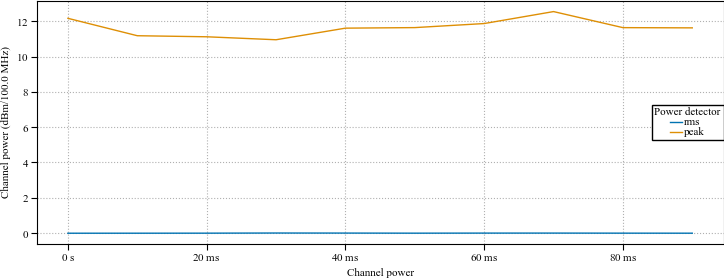

In [6]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cellular cyclic autocorrelation

In [7]:
cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
    frame_range=(0,1),
    # slot_range=(0,1),
    # symbol_range=(0,1)
).to_xarray()

In [23]:
%%timeit -n1 -r1

cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
    frame_range=(0,1),
    slot_range=(0,5),
    # symbol_range=(0,1)
).to_xarray()

457 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# def profile():
#     return channel_analysis.cellular_cyclic_autocorrelation(
#         iq,
#         capture,
#         subcarrier_spacings=(15e3, 30e3, 60e3),
#         frame_range=(0,1),
#         # slot_range=(0,1),
#         # symbol_range=(0,1)
#     )


# # benchmark(profile, n_repeat=10)
# benchmark(lambda: profile().to_xarray(), n_repeat=10)

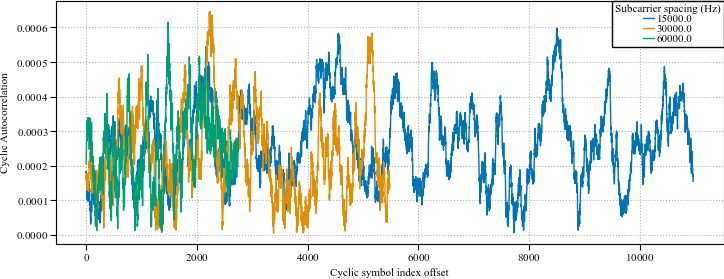

In [24]:

fig, ax = plt.subplots()

cyclic_autocorrelation.plot.line(x='cyclic_sample_lag', ax=ax)
# figures.label_legend(ax, cyclic_autocorrelation, 'subcarrier_spacing')

### Cyclic channel power

In [11]:
cyclic_power = channel_analysis.cyclic_channel_power(
    iq,
    capture,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    power_detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

In [12]:
def profile():
    return channel_analysis.cyclic_channel_power(
        iq,
        capture,
        cyclic_period=10e-3,
        detector_period=1e-3 / 15 / 4,
        power_detectors=pvt.power_detector.values,
        cyclic_statistics=('min', 'mean', 'max'),
    )


benchmark(lambda: profile().to_xarray(), n_repeat=10)

<lambda>            :    CPU: 187846.840 us   +/- 436.739 (min: 187351.200 / max: 188953.500) us     GPU-0: 187894.029 us   +/- 451.588 (min: 187386.780 / max: 189034.149) us

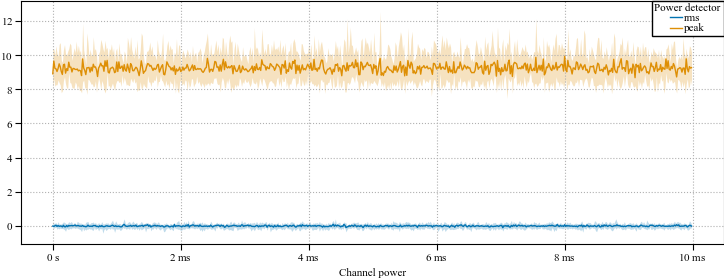

In [13]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, (a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        (a.sel(cyclic_statistic='min')),
        (a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [14]:
frequency_resolution = 15e3
spectrum_quantiles = [0.5, 0.75, 0.95, 0.99, 1]

spectrum = channel_analysis.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    frequency_resolution=frequency_resolution,
    persistence_statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=True
).to_xarray()

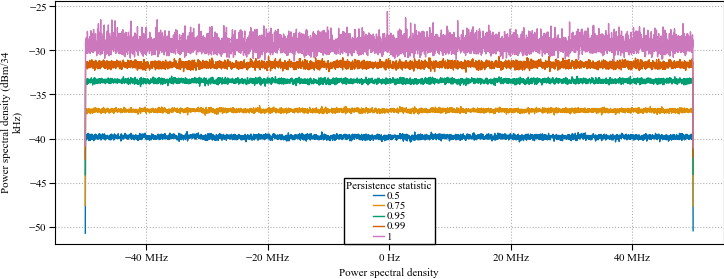

In [15]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

In [16]:
def profile():
    return channel_analysis.persistence_spectrum(
        iq,
        capture,
        window=('dpss', 3),
        frequency_resolution=frequency_resolution,
        persistence_statistics=spectrum_quantiles,
        fractional_overlap=0.0,
        truncate=True,
    )


benchmark(profile, n_repeat=1)
# benchmark(lambda: profile().to_xarray(), n_repeat=10)

# %%timeit -n1 -r1

profile             :    CPU: 1693930.200 us     GPU-0: 1694264.282 us

### Amplitude Probability Distribution

In [17]:
apd_bins = dict(power_low=-60.0, power_high=15.0, power_resolution=0.25)

apd = channel_analysis.channel_power_ccdf(iq, capture, **apd_bins).to_xarray()

In [18]:
%%timeit -n1 -r1

channel_analysis.channel_power_ccdf(iq, capture, **apd_bins).to_xarray()

366 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


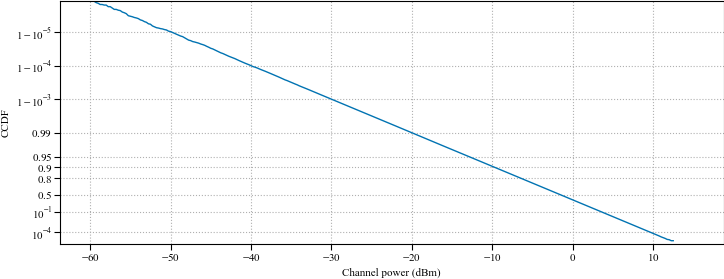

In [19]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd,  'channel_power_bin', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Putting it all together

In [20]:
# %%timeit -n1 -r1

del iq

iq = channel_analysis.simulated_awgn(capture, xp=cp, pinned_cuda=True)
iq = channel_analysis.filter_iq_capture(iq, capture)

analysis_spec = {
    'channel_power_time_series': {'detector_period': 10e-3, 'power_detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'power_detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        # 'window': 'flattop',
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
        'frequency_resolution':15e3,
        'persistence_statistics': [0.5, 0.75, 0.95, 0.99, 1],
        'truncate': True,
    },
    'channel_power_ccdf': {
        'power_low': -40,
        'power_high': 15,
        'power_resolution': 221,  # 0.25 dB resolution
    },
}

filter_spec = {
    'nfft': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

result =  channel_analysis.analyze_by_spec(iq, capture, spec=analysis_spec)
result

<xarray.Dataset> Size: 204kB
Dimensions:                    (channel_power_bin: 1, power_detector: 2,
                                time_elapsed: 10, cyclic_statistic: 3,
                                cyclic_lag: 600, persistence_statistic: 5,
                                baseband_frequency: 6667)
Coordinates:
  * channel_power_bin          (channel_power_bin) float32 4B -40.0
  * power_detector             (power_detector) object 16B 'rms' 'peak'
  * time_elapsed               (time_elapsed) float32 40B 0.0 0.01 ... 0.08 0.09
  * cyclic_statistic           (cyclic_statistic) object 24B 'min' 'mean' 'max'
  * cyclic_lag                 (cyclic_lag) float32 2kB 0.0 ... 0.009983
  * persistence_statistic      (persistence_statistic) object 40B '0.5' ... '...
  * baseband_frequency         (baseband_frequency) float64 53kB -5e+07 ... 5...
Data variables:
    channel_power_ccdf         (channel_power_bin) float32 4B 0.9999
    channel_power_time_series  (power_detector, time_elapsed) float32 80B -0....
    cyclic_channel_power       (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    persistence_spectrum       (persistence_statistic, baseband_frequency) float32 133kB ...
Attributes:
    analysis_filter:     {'nfft': 8192, 'window': 'hamming'}
    duration:            0.1
    sample_rate:         153600000.0
    analysis_bandwidth:  100000000.0

In [21]:
def profile():
    return  channel_analysis.analyze_by_spec(iq, capture, spec=analysis_spec)


benchmark(profile, n_repeat=2)

profile             :    CPU: 2368850.400 us   +/- 408.600 (min: 2368441.800 / max: 2369259.000) us     GPU-0: 2368876.465 us   +/- 409.668 (min: 2368466.797 / max: 2369286.133) us